In [1]:
import re

def loadxvg(filename):
    ls = []
    for line in open(filename):
        if not line.startswith('#') and not line.startswith('@'):
            l = re.split('\s+', line.strip())
            if len(l) == 2:
                ls.append(float(l[1]))
    return ls

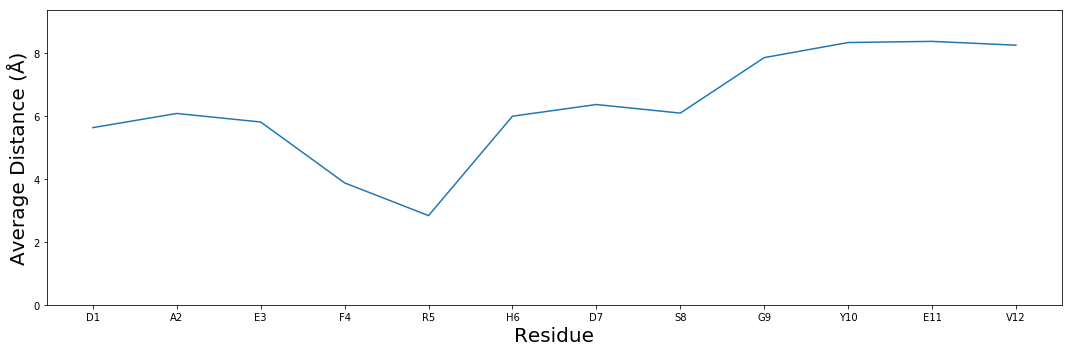

In [7]:
import numpy as np
import matplotlib.pyplot as plt

ls = []
n = 12
for i in range(n):
    filename = 'r{0}.xvg'.format(i + 1)
    d = np.array(loadxvg(filename)) * 10
    avg = np.mean(d)
    ls.append(avg)

seq = 'DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA'
x = range(n)
labels = ['{0}{1}'.format(seq[i], i + 1) for i in x]
y = ls

plt.figure(figsize=(15,5))
plt.plot(range(n), ls)
plt.ylim(0, np.max(y)+1)
plt.xticks(x, labels)
plt.xlabel('Residue', fontsize=20)
plt.ylabel('Average Distance (\u212b)', fontsize=20)
plt.tight_layout()
plt.show()



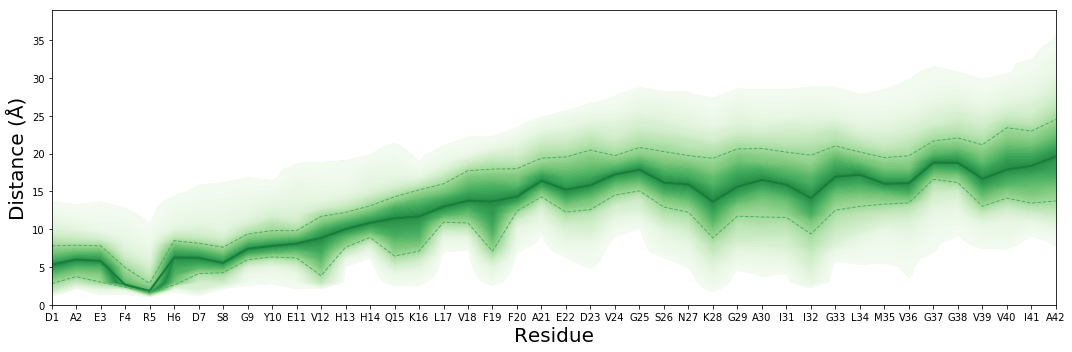

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# import cmocean.cm as cmap
from matplotlib import cm

# cm = cmap.blues
cmap = cm.get_cmap('Greens')

data = []

avgs = []
n = 42
q50 = []
q0 = []
q100 = []
q25 = []
q75 = []
for i in range(n):
    filename = 'r{0}.xvg'.format(i + 1)
    d = np.array(loadxvg(filename)) * 10
    data.append(d)
    avg = np.mean(d)
    avgs.append(avg)
    q0.append(np.percentile(d, 0))
    q50.append(np.percentile(d, 50))
    q100.append(np.percentile(d, 100))
    q25.append(np.percentile(d, 25))
    q75.append(np.percentile(d, 75))
    
def foo(x, y):
    return stats.percentileofscore(data[int(x)], y)

seq = 'DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA'
x = np.arange(0, n, 1)
y = np.arange(0, 40, 1)
labels = ['{0}{1}'.format(seq[i], i + 1) for i in x]
# y = ls

X, Y = np.meshgrid(x, y)
Z = []
for i in x:
    ls = []
    for j in y:
        z = foo(i, j)
        ls.append(z)
    Z.append(ls)
Z = np.array(Z)

nlevels = 100
colors = []
for i in range(nlevels):
    j = i / 100.0
    if j<0.02 or j>0.98:
        c = 'w'
    elif j < 0.5:
        c = cmap(j * 1.5)
    else:
        c = cmap((1 - j) * 1.5)
    colors.append(c)

plt.figure(figsize=(15,5))
plt.contourf(x, y, Z.T, nlevels, colors=colors)
plt.plot(x, q50, color=cmap(0.8), lw=2)
# plt.plot(x, q0, color=cmap(0.6), lw=1, ls='--')
# plt.plot(x, q100, color=cmap(0.6), lw=1, ls='--')
plt.plot(x, q25, color=cmap(0.6), lw=1, ls='--')
plt.plot(x, q75, color=cmap(0.6), lw=1, ls='--')
plt.xticks(x, labels)
plt.xlabel('Residue', fontsize=20)
plt.ylabel('Distance (\u212b)', fontsize=20)
plt.tight_layout()
plt.savefig('distance.svg')
plt.savefig('distance.png', dpi=500)
plt.savefig('distance.pdf')





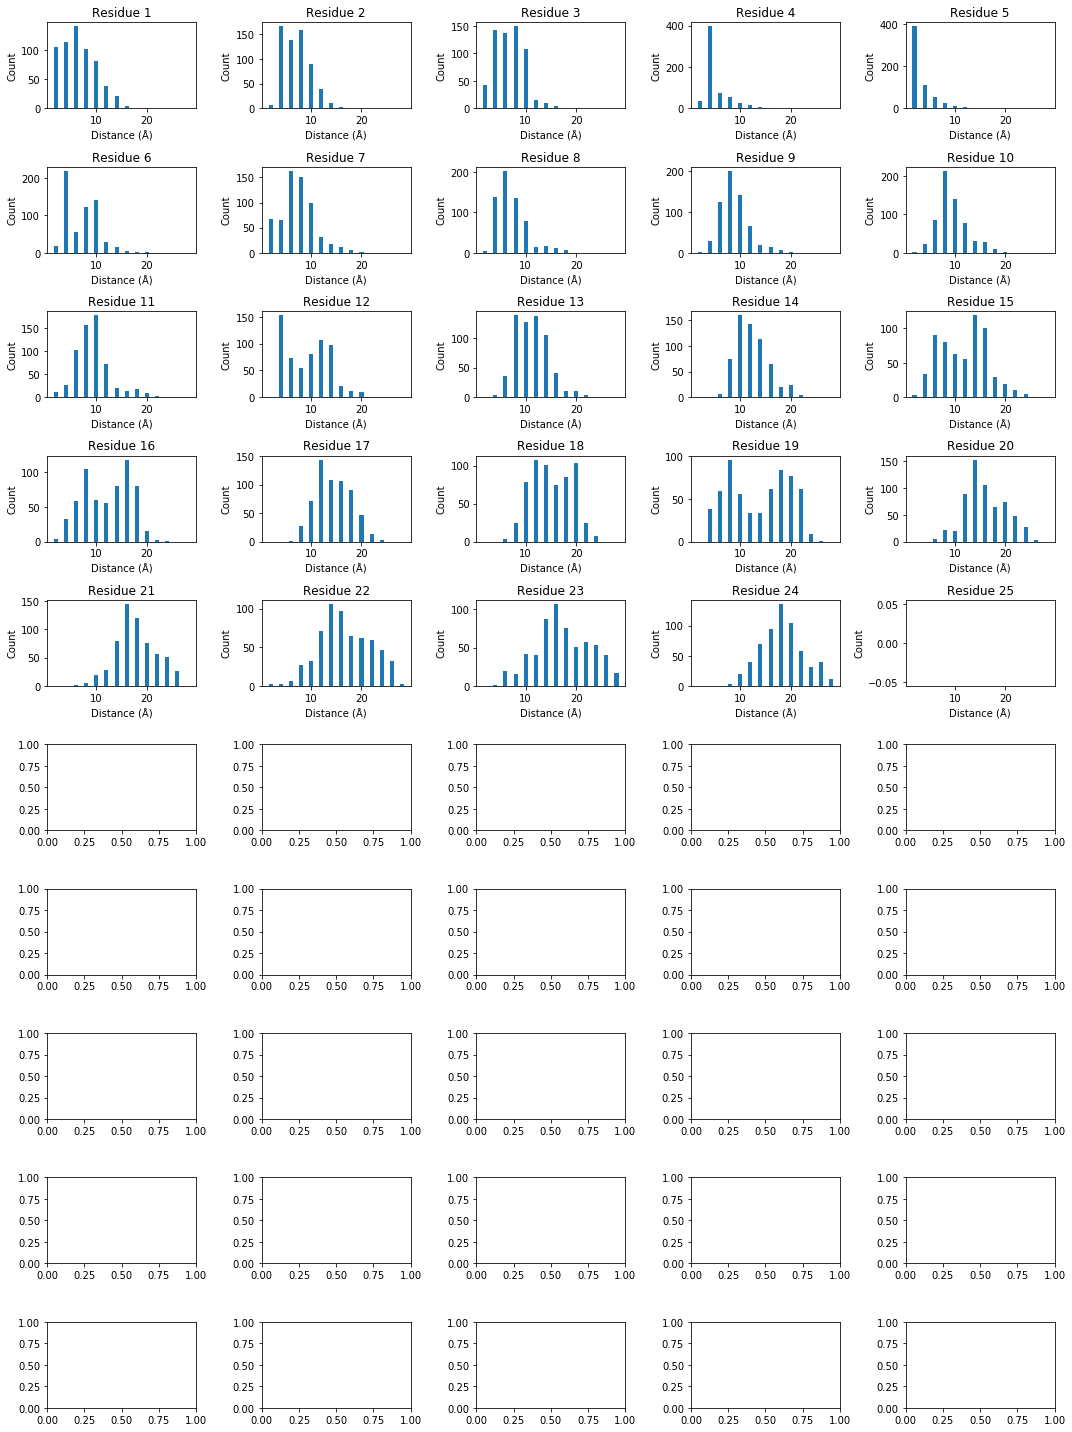

In [25]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=10, ncols=5)

fig.set_figheight(20)
fig.set_figwidth(15)

n = 24
maxdist = 30

i = 0
for row in ax:
    for col in row:
        if i < n:
            filename = 'r{0}.xvg'.format(i + 1)

            d = np.array(loadxvg(filename)) * 10
            n = len(d)

            bins = np.arange(0,maxdist,2)
            count, _ = np.histogram(d, bins=bins)

            col.bar(bins[1:], count)
            col.set_xlabel('Distance (\u212b)')
            col.set_ylabel('Count')
            col.set_title('Residue {0}'.format(i + 1))
        
        i += 1


plt.tight_layout()
plt.show()

In [47]:
from scipy import stats

x = np.arange(0, 42, 1)
y = np.arange(0, 42, 1)

stats.percentileofscore(x, 2)

7.142857142857143

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
np.random.seed(1977)

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im


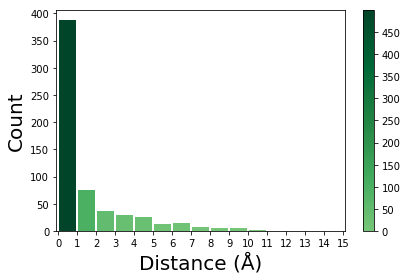

In [204]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import cmocean.cm
from matplotlib import cm

# cmap = cmocean.cm.haline
cmap = cm.get_cmap('YlGn')

data = []
for i in range(n):
    filename = 'r{0}.xvg'.format(i + 1)
    d = np.array(loadxvg(filename)) * 10
    data.append(d)

bin = 1   

d = data[4]
mx = np.max(d)
bins = np.arange(0, mx, bin)
count, _ = np.histogram(d, bins=bins)

x = bins[:-1]
y = count
colors=[cmap(i * 0.5 / np.max(count) + 0.5) for i in y]

plt.bar(np.array(x) - bin * 0.5, y, width=bin*0.9, color=colors)
plt.xticks(x)
plt.xlim(-0.1,15.1)

# plt.xticks(x, labels)
plt.xlabel('Distance (\u212b)', fontsize=20)
plt.ylabel('Count', fontsize=20)
norm = mpl.colors.Normalize(vmin=0,vmax=400)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, boundaries=np.arange(200,400,.1))
cbar.ax.set_yticklabels(np.arange(0, 500, 50))
plt.tight_layout()
# plt.show()
plt.savefig('hist5.svg')
plt.savefig('hist5.png', dpi=500)



